##### Pre-Process images with HOG and colorspace, etc and use SVM model to train them
##### Or Send original images to CNN directly without any manual feature extraction
##### Compare the results of the 2 methods above

#### Pipeline: 
1. Import all the train dataset
2. Process the images with HOG and colorspace
3. Train the processed images with SVM
4. Train the original images with CNN
5. Compare the accuracy between the 2 results to find which one performs better
6. ...

In [1]:
## libraries import

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

import tensorflow as tf

## I am using scikit-learn 0.19
from sklearn.model_selection import train_test_split

D:\Qiwei\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#### Image augmentation: 1. scale up to 1.2 and down to 0.8, 2. flip the image left and right, up and down NOT needed. 

In [2]:
def image_aug(image):
    
    # 1. Resize the images to 64x64x3 first
    aug1 = cv2.resize(image,(64,64))
    
    # 2. Scale up the vehicle size in the image to 1.2
    aug2 = cv2.resize(aug1[12:52,8:56,:],(64,64))
    
    # 2. Scale down the vehicle size in the image to 0.8
    reflect = cv2.copyMakeBorder(aug1,4,4,16,16,cv2.BORDER_REPLICATE)
    aug3 = cv2.resize(reflect, (64,64))
    
    # 3. Flip all the iamges along with the column
    flip1 = cv2.flip(aug1, 1)
    flip2 = cv2.flip(aug2, 1)
    flip3 = cv2.flip(aug3, 1)
    
    image_list = []
    
    image_list.append(aug1)
    image_list.append(aug2)
    image_list.append(aug3)
    image_list.append(flip1)
    image_list.append(flip2)
    image_list.append(flip3)
    
    return image_list

### 1. Prepare dataset

There are total 8797 vehicle images and 8968 non-vehicle images. However, the serial number of vehilce images are not in order, therefore they have to be reorganized in order first before sent to train. 

![vehicle images](output_images/vehicle dataset.jpg)

In [3]:
# create path for vechile iamges
vehicle_path1 = './dataset/vehicles/GTI_Far/'
vehicle_path2 = './dataset/vehicles/GTI_Left/'
vehicle_path3 = './dataset/vehicles/GTI_MiddleClose/'
vehicle_path4 = './dataset/vehicles/GTI_Right/'
vehicle_path5 = './dataset/vehicles/KITTI_extracted/'
# create a list to include these paths
path = []
path.append(vehicle_path1),path.append(vehicle_path2),path.append(vehicle_path3)
path.append(vehicle_path4),path.append(vehicle_path5)

#add GTI and KITTI dataset, and create vehicle label
# 1 for vehicle and 0 for non-vehicle
vehicle = []
label_v = []
for i in range(0,5):
    for filename in glob.glob(path[i] + '*'):
        img = cv2.imread(filename)
        vehicle.append(img)
        label_v.append(1)
print('number of vehicle images and labels: ', len(vehicle),len(label_v))

number of vehicle images and labels:  8792 8792


In [4]:
#add GTI and KITTI dataset, and create non vehicle label
# 1 for vehicle and 0 for non-vehicle
nonpath = './dataset/non_vehicles/'
non_vehicle = []
label_nv = []
for filename in glob.glob(nonpath + '*'):
    
    ## BGR order because cv2
    img = cv2.imread(filename)
    non_vehicle.append(img)
    label_nv.append(0)
print('number of non-vehicle images and labels: ', len(non_vehicle),len(label_nv))


number of non-vehicle images and labels:  8968 8968


In [5]:
## Create train set for SVM model

data_svm = vehicle + non_vehicle
label_svm = label_v + label_nv

print('number of images and labels: ', len(data_svm),len(label_svm))

number of images and labels:  17760 17760


In [6]:
# create a complete dataset for training

#apply image augmentation
veh_images = []
temp1_label = []
for i in range(len(vehicle)):
    temp1 = image_aug(vehicle[i])
    veh_images.append(temp1)
    for j in range(len(temp1)):
        temp1_label.append(1)
vehicle = np.concatenate(veh_images)

nonveh_images = []
temp2_label = []
for i in range(len(non_vehicle)):
    temp2 = image_aug(non_vehicle[i])
    nonveh_images.append(temp2)
    for j in range(len(temp2)):
        temp2_label.append(0)
non_vehicle = np.concatenate(nonveh_images)

train = np.concatenate((vehicle,non_vehicle))
label = np.concatenate((temp1_label,temp2_label))

print(len(train),len(label))

106560 106560


#### The number of images used to train the  CNN model is 106,560, and the number of images used to train SVM model 17,760, because the accuracy would drop significantly if the augmented images had been used to train the SVM model.  

In [7]:
del vehicle,non_vehicle

## randomly check the shape of images
print(train[10012].shape)
print(train[112].shape)
print(train[999].shape)

## all the images have same shape

(64, 64, 3)
(64, 64, 3)
(64, 64, 3)


### 2. Feature extraction using HOG and colorspace

Generally, nerual networks models do not need feature extraction. In this project, a comparison is made to figure it out if feature extraction using HOG and colorspace can improve the accuracy of CNN model. 

#### 2.1 HOG feature

In [8]:
from skimage.feature import hog

def hog_feature(image,channel = 'gray'):
    """
    The current verison of skimage.feature.hog() can only accept one channel image.
    For the future version, it will have option for multichannel image.
    The default channel is to use gray, while other color channels are also optional.
    
    feature vectors and hog_draw are returned for later usage. 
    
    convert image to 32x32 size
    """
    if image.shape[0] != 32:
        image = cv2.resize(image,(32,32))
    if channel == 'blue':
        single = image[:,:,0]
    elif channel == 'green':
        single = image[:,:,1]  
    elif channel == 'red':
        single = image[:,:,2]
    else:
        single = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    features, hog_draw = hog(single, orientations=9, pixels_per_cell=(8, 8), 
    cells_per_block=(2, 2), block_norm='L2-Hys', visualise=True, 
    transform_sqrt=False, feature_vector=True)
    return features, hog_draw

### 2.2 HOG feature only accuracy

In [9]:
def hog_color_channel(color='gray'):
    hog_feature_vector = []
    start = time.time()
    for i in range(len(train)):
        features, _ = hog_feature(train[i],channel = color)
        hog_feature_vector.append(features)

    # convert list to np.array format
    X = np.array(hog_feature_vector)
    y = np.array(label)

    #randomly shuffle the dataset to prevent errors caused by sequence of the data
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
    X,y, test_size=0.2, random_state=rand_state)

    # Fit a per-column scaler only on the training data
    # only fit X_train data, No X_test, otherwise we peek the test data
    X_scaler = StandardScaler().fit(X_train)
    # Apply the scaler to X_train and X_test
    X_train = X_scaler.transform(X_train)
    X_test = X_scaler.transform(X_test)

    svc = LinearSVC()
    svc.fit(X_train, y_train)
    end = time.time()
    print(round(end-start, 2), f'Seconds to train SVC using {color} hog features')
    # Check the score of the SVC
    print(f'Test Accuracy of SVC using {color} hog features = ', round(svc.score(X_test, y_test), 3))
    print()

In [119]:
color_order = ['gray','blue','green','red']
for color in color_order:
    hog_color_channel(color=color)

462.24 Seconds to train SVC using gray hog features
Test Accuracy of SVC using gray hog features =  0.912

470.67 Seconds to train SVC using blue hog features
Test Accuracy of SVC using blue hog features =  0.917

245.25 Seconds to train SVC using green hog features
Test Accuracy of SVC using green hog features =  0.906

266.03 Seconds to train SVC using red hog features
Test Accuracy of SVC using red hog features =  0.905



### Observation: the blue channel HOG feature generated 0.917 accuray. 

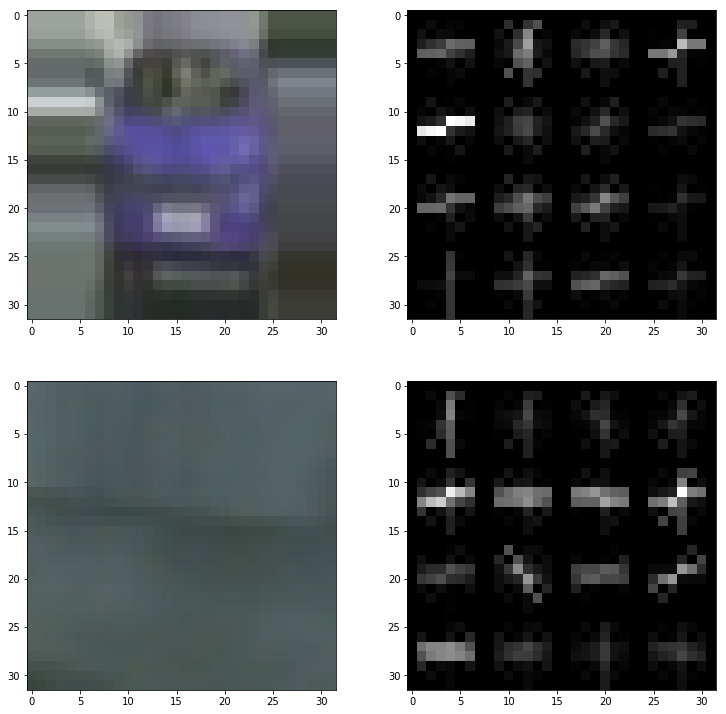

In [11]:
# randomly select an image to visualize

vehicle_image = train[500]
non_vehicle_image = train[88000]

features1, draw1 = hog_feature(vehicle_image)

features2, draw2 = hog_feature(non_vehicle_image)

fig = plt.figure(figsize=(12.5,12.5))
fig.add_subplot(221)
plt.imshow(vehicle_image,cmap='gray')
fig.add_subplot(222)
plt.imshow(draw1,cmap='gray')

fig.add_subplot(223)
plt.imshow(non_vehicle_image,cmap='gray')
fig.add_subplot(224)
plt.imshow(draw2,cmap='gray')

## 2.3 Colorsapce feature only accuracy

Using the same example images as HOG feature

In [10]:
vehicle_image = train[500]
non_vehicle_image = train[12000]

def channel_hist(image,bins=32,range=(0,256)):
#because cv2.imread was used, so the color channel order was BGR. 
    chan1 = np.histogram(vehicle_image[:,:,0], bins=32, range=(0, 256))
    chan2 = np.histogram(vehicle_image[:,:,0], bins=32, range=(0, 256))
    chan3 = np.histogram(vehicle_image[:,:,0], bins=32, range=(0, 256))
    channel_feature = np.concatenate((chan1[0], chan2[0], chan3[0]))
    return channel_feature

In [53]:
print(v_bhist)

(array([   0,    0,   62,  649, 1090,  892,  395,  275,  106,  121,   75,
         77,   65,   50,   52,   48,   49,   31,   23,   20,   14,    1,
          0,    1,    0,    0,    0,    0,    0,    0,    0,    0],
      dtype=int64), array([  0.,   8.,  16.,  24.,  32.,  40.,  48.,  56.,  64.,  72.,  80.,
        88.,  96., 104., 112., 120., 128., 136., 144., 152., 160., 168.,
       176., 184., 192., 200., 208., 216., 224., 232., 240., 248., 256.]))


In [57]:
# Using the center line of each histogram to represent the histogram

# create a new list "bin_edges[1:]" starting from the second element of the original list
bin_edges = v_bhist[1]
bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
print(bin_centers)

[  4.  12.  20.  28.  36.  44.  52.  60.  68.  76.  84.  92. 100. 108.
 116. 124. 132. 140. 148. 156. 164. 172. 180. 188. 196. 204. 212. 220.
 228. 236. 244. 252.]


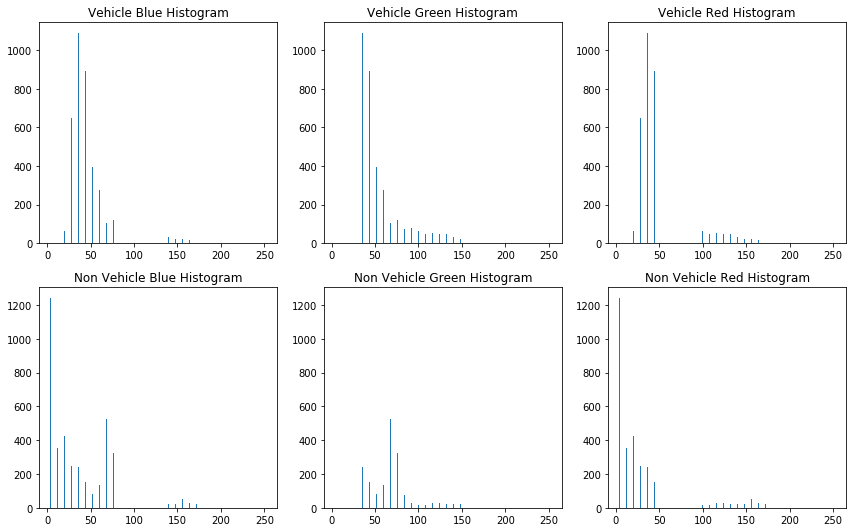

In [66]:
fig = plt.figure(figsize=(12,7.5))
fig.add_subplot(231)
plt.bar(bin_centers,v_bhist[0])
plt.title('Vehicle Blue Histogram')
fig.add_subplot(232)
plt.bar(bin_centers,v_ghist[0])
plt.title('Vehicle Green Histogram')
fig.add_subplot(233)
plt.bar(bin_centers,v_rhist[0])
plt.title('Vehicle Red Histogram')

fig.add_subplot(234)
plt.bar(bin_centers,nv_bhist[0])
plt.title('Non Vehicle Blue Histogram')
fig.add_subplot(235)
plt.bar(bin_centers,nv_ghist[0])
plt.title('Non Vehicle Green Histogram')
fig.add_subplot(236)
plt.bar(bin_centers,nv_rhist[0])
plt.title('Non Vehicle Red Histogram')
print()

### Convert RGB colorspace to other spaces. Experiments will be made among these colorspaces to find the one that generates highest accuracy. 

In [11]:
## create colorspace feature using different color_space conversion
## Experiments will be needed to find out the color_space with best performance

def colorspace_feature(img, color_space='BGR', size=(32, 32)):
    # Convert image to new color space (if specified)
 #   if color_space != 'BGR':
 #       if color_space == 'HSV':
 #           feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
 #       elif color_space == 'LUV':
 #           feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
 #       elif color_space == 'HLS':
 #           feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
 #       elif color_space == 'YUV':
 #           feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
 #       elif color_space == 'YCrCb':
 #           feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
  #  else: feature_image = np.copy(img)    
    feature_image = np.copy(img)   
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features, feature_image

In [12]:
#combine color space with histogram features together

def extract_features(image, cspace='LUV', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    cspace_features, cvtimage = colorspace_feature(image,color_space=cspace,size=spatial_size)
    channel_features = channel_hist(cvtimage,bins=hist_bins,range=hist_range)
    features = np.concatenate((cspace_features, channel_features))
    return features

### 2.4 Color space classifier trial and error test

In [15]:
## show the raw dataset, need to process 
print('number of images and labels: ', len(train),len(label))

number of images and labels:  106560 106560


In [13]:
## create a pipeline to check the performance of each colorspace
def check_colorspace_accuracy(train,label,cspace='BGR'):
    #create a vector to store all color features
    feature_vectors = []
    #start to time
    start=time.time()
    for i in range(len(train)):
        X_cspace = []
        X_cspace = extract_features(train[i], cspace=color, spatial_size=(32, 32),
                                          hist_bins=32, hist_range=(0, 256))
        feature_vectors.append(X_cspace)
    
    # convert list to np.array format
    X = np.array(feature_vectors)
    y = np.array(label)
    
    #randomly shuffle the dataset to prevent errors caused by sequence of the data
    rand_state = np.random.randint(0, 100)
    SVM_X_train, SVM_X_test, SVM_y_train, SVM_y_test = train_test_split(
    X,y, test_size=0.2, random_state=rand_state)

    # Fit a per-column scaler only on the training data
    # only fit X_train data, No X_test, otherwise we peek the test data
    X_scaler = StandardScaler().fit(SVM_X_train)
    # Apply the scaler to X_train and X_test
    SVM_X_train = X_scaler.transform(SVM_X_train)
    SVM_X_test = X_scaler.transform(SVM_X_test)

    svc = LinearSVC()
    svc.fit(SVM_X_train, SVM_y_train)
    end = time.time()
    print(round(end-start, 2), f'Seconds to train SVC using {cspace} colorspace')
    # Check the score of the SVC
    print(f'Test Accuracy of SVC using {cspace} colorspace= ', round(svc.score(SVM_X_test, SVM_y_test), 3))
    print()

In [107]:
color_list = ['BGR','HSV','LUV','YUV','YCrCb']

for color in color_list:
    check_colorspace_accuracy(train,label,cspace=color)

D:\Anaconda3\envs\carnd-term1\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


63.63 Seconds to train SVC using BGR colorspace
Test Accuracy of SVC using BGR colorspace=  0.909

54.46 Seconds to train SVC using HSV colorspace
Test Accuracy of SVC using HSV colorspace=  0.878

54.24 Seconds to train SVC using LUV colorspace
Test Accuracy of SVC using LUV colorspace=  0.902

49.3 Seconds to train SVC using YUV colorspace
Test Accuracy of SVC using YUV colorspace=  0.901

51.08 Seconds to train SVC using YCrCb colorspace
Test Accuracy of SVC using YCrCb colorspace=  0.901



#### Observation: RGB colorspace generated best performance at the expense of computional cost. YUV seems a better choice because it has better balance between accuracy and computional time.

### 2.5 Combine HOG and Colorspace features

Using blue color channel in HoG feature and LUV colorspace. 

In [14]:
hog_color_features = []
start = time.time()
for i in range(len(data_svm)):
    hog_vector, _ = hog_feature(data_svm[i],channel = 'blue')

    color_vector = extract_features(data_svm[i], cspace='LUV', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))
    
    #combine features from 2 different sources
    temp_features = np.concatenate((hog_vector,color_vector))
    hog_color_features.append(temp_features)
    
X = np.array(hog_color_features)
y = np.array(label_svm)

rand_state = np.random.randint(0, 100)
SVM_X_train, SVM_X_test, SVM_y_train, SVM_y_test = train_test_split(
X,y, test_size=0.2, random_state=rand_state)

# Fit a per-column scaler only on the training data
# only fit X_train data, No X_test, otherwise we peek the test data
X_scaler = StandardScaler().fit(SVM_X_train)
# Apply the scaler to X_train and X_test
SVM_X_train = X_scaler.transform(SVM_X_train)
SVM_X_test = X_scaler.transform(SVM_X_test)

svc = LinearSVC()
svc.fit(SVM_X_train, SVM_y_train)
end = time.time()
print(round(end-start, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print(f'Test Accuracy of SVC using HoG and colorspace = ', round(svc.score(SVM_X_test, SVM_y_test), 3))
print()

63.67 Seconds to train SVC...
Test Accuracy of SVC using HoG and colorspace =  0.952



### The accuracy of SVM using HOG and colorspace features was 0.952, which needs further improvement. 

In [15]:
## create a pipleline for later use in the video
def prepare_feature(image):
    hog_color_features = []
    hog_vector, _ = hog_feature(image,channel = 'blue')
  #  print(len(hog_vector))
    color_vector = extract_features(image, cspace='LUV', spatial_size=(32, 32),
                            hist_bins=32, hist_range=(0, 256))
  #  print(len(color_vector))
    temp_features = np.concatenate((hog_vector,color_vector))
    hog_color_features.append(temp_features)
    final_features = np.array(hog_color_features)
    return final_features

In [16]:
svc.predict(SVM_X_test)

array([0, 1, 1, ..., 0, 1, 0])

In [17]:
print(SVM_X_test.shape)

(3552, 3492)


In [547]:
for i in range(5):
    print(train[i].shape)
    svmfeature = prepare_feature(train[i])
    svm_features = X_scaler.transform(svmfeature)
    print(svmfeature.shape)
    print(svc.predict(svm_features))

(64, 64, 3)
(1, 3492)
[1]
(64, 64, 3)
(1, 3492)
[1]
(64, 64, 3)
(1, 3492)
[1]
(64, 64, 3)
(1, 3492)
[1]
(64, 64, 3)
(1, 3492)
[1]


#### Observation: The overall accuracy was improved to 0.957 after combining 2 kinds of features.

### 3. CNN architecture model comparison

#### 3.1 The CNN architecture in this project was modified from the one built in my traffic sign project

In [17]:
## Resize and normalize the images
new_train = []
for i in range(len(train)):
    
    #resize the image to its half size
    temp = cv2.resize(train[i], dsize=None, fx=0.5, fy=0.5)
    #normalize the image from 0:255 scale to 0:1 scale
    temp = temp/255
    new_train.append(temp)

In [18]:
## CNN Model architecture summary
import pandas as pd
CNN_summary = pd.read_csv('CNN Architecture summary.csv')
CNN_summary

,Input Shape,Layer
0,batch_sizex32x32x3,Convolution 5x5x3x10
1,batch_sizex28x28x10,"Max Pooling (valid, strides = 1x2x2x1)"
2,batch_sizex14x14x10,Activation (ReLU)
3,batch_sizex14x14x10,"Convolution (valid, 5x5x1x30)"
4,batch_sizex10x10x30,"Max Pooling (valid,strides = 1x2x2x1)"
5,batch_sizex5x5x30,Activation (ReLU)
6,batch_sizex5x5x30,Flatten
7,batch_sizex750,Full-connected layer(750x120)
8,batch_sizex120,Activation (ReLU)
9,batch_sizex120,Full-connected layer (120x2)


#### 3.2 CNN architecture build

In [19]:

from tensorflow.contrib.layers import flatten

In [20]:


## random split train and test data
rand_state = np.random.randint(0, 100)
Xtrain, X_test, ytrain, y_test = train_test_split(
new_train,label, test_size=0.2, random_state=rand_state)


## random split train and validate data from the previous training data
rand_state = np.random.randint(0, 100)
X_train, X_valid, y_train, y_valid = train_test_split(
Xtrain,ytrain, test_size=0.2, random_state=rand_state)

EPOCHS = 20
BATCH_SIZE = 512

In [21]:
def CNN_model(x):
    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    keep_prob = 0.9
    mu = 0
    sigma = 0.1
    # note: input dimension ("batch_size", height, width, depth)
    # Layer 1: Convolutional. Input = "batch_size"x32x32x3. Output = "batch_size"x28x28x6.
    # The shape of the filter weight is (height, width, input_depth, output_depth)
    c1_w = tf.Variable(tf.truncated_normal(shape=(5,5,3,10),mean = mu, stddev = sigma))
    c1_b = tf.Variable(tf.zeros(10))
    #Set the stride for each dimension (batch_size, height, width, depth)
    c1   = tf.nn.conv2d(x, c1_w, strides = [1,1,1,1], padding ='VALID') + c1_b  
    c1 = tf.nn.relu(c1)
    c1 = tf.nn.dropout(c1, keep_prob)
    # Pooling. Input = "batch_size"x28x28x6. Output = "batch_size"x14x14x6.
    c1 = tf.nn.max_pool(c1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    #Set the ksize (filter size) for each dimension (batch_size, height, width, depth)
    #Set the stride for each dimension (batch_size, height, width, depth)


    # Layer 2: Convolutional, input "batch_size"x14x14x10, Output = "batch_size"x10x10x30.
    c2_w = tf.Variable(tf.truncated_normal((5,5,10,30),mean=mu,stddev=sigma))
    c2_b = tf.Variable(tf.zeros(30))
    c2   = tf.nn.conv2d(c1, c2_w, strides = [1,1,1,1],padding = 'VALID') + c2_b
    
    # Activation.
    c2 = tf.nn.relu(c2)
    c2 = tf.nn.dropout(c2, keep_prob)
    # Pooling. Input = "batch_size"x10x10x30. Output = "batch_size"x5x5x30.    
    c2 = tf.nn.max_pool(c2,ksize = [1,2,2,1],strides = [1,2,2,1], padding = 'VALID')

    # Flatten. Input = "batch_size"x5x5x30. Output = "batch_size"x750.
    flatten0 = flatten(c2)
    
    # Layer 3: Fully Connected. Input = "batch_size"x750. Output = "batch_size"x200.
    flatten1_w = tf.Variable(tf.truncated_normal(shape=(750,200), mean = mu, stddev = sigma))
    flatten1_b = tf.Variable(tf.zeros(200))
    flatten1 = tf.matmul(flatten0, flatten1_w) + flatten1_b
    
    # Activation.
    flatten1 = tf.nn.relu(flatten1)
    flatten1 = tf.nn.dropout(flatten1, keep_prob)

    # Layer 4: Fully Connected. Input = "batch_size"x200. Output = "batch_size"x100.
    flatten2_w = tf.Variable(tf.truncated_normal(shape=(200,100), mean = mu, stddev = sigma))
    flatten2_b = tf.Variable(tf.zeros(100))
    flatten2 = tf.matmul(flatten1, flatten2_w) + flatten2_b
    # Activation.
    flatten2 = tf.nn.relu(flatten2)
    flatten2 = tf.nn.dropout(flatten2, keep_prob)
    # Layer 5: Fully Connected. Input = 100. Output = 2
    flatten3_w = tf.Variable(tf.truncated_normal(shape=(100,2), mean = mu, stddev = sigma))
    flatten3_b = tf.Variable(tf.zeros(2))
    flatten2 = tf.nn.sigmoid(flatten2) ##optional
    logits = tf.matmul(flatten2, flatten3_w) + flatten3_b
    
    return logits    

### Features and Labels
x is a placeholder for a batch of input images. y is a placeholder for a batch of output labels.

In [22]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 2)

In [23]:
## Training Pipeline
learningrate = 0.001

logits = CNN_model(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = learningrate)
training_operation = optimizer.minimize(loss_operation)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



#### Model Evaluation
Evaluate how well the loss and accuracy of the model for a given dataset.

In [24]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))

accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()


In [25]:

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

#### Train, Validate and Test the Model
A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [26]:
from sklearn.utils import shuffle
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        train_accuracy = evaluate(X_train, y_train)
        print("EPOCH {} ...".format(i+1), ", Train Accuracy = {:.3f}".format(train_accuracy),", Validation Accuracy = {:.3f}".format(validation_accuracy))
     #   print("Train Accuracy = {:.3f}".format(train_accuracy))
     #   print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './vehicle_detect')
    print("Model saved")

Training...

EPOCH 1 ... , Train Accuracy = 0.932 , Validation Accuracy = 0.930

EPOCH 2 ... , Train Accuracy = 0.947 , Validation Accuracy = 0.947

EPOCH 3 ... , Train Accuracy = 0.976 , Validation Accuracy = 0.973

EPOCH 4 ... , Train Accuracy = 0.982 , Validation Accuracy = 0.980

EPOCH 5 ... , Train Accuracy = 0.965 , Validation Accuracy = 0.963

EPOCH 6 ... , Train Accuracy = 0.985 , Validation Accuracy = 0.982

EPOCH 7 ... , Train Accuracy = 0.985 , Validation Accuracy = 0.982

EPOCH 8 ... , Train Accuracy = 0.983 , Validation Accuracy = 0.981

EPOCH 9 ... , Train Accuracy = 0.991 , Validation Accuracy = 0.986

EPOCH 10 ... , Train Accuracy = 0.991 , Validation Accuracy = 0.988

EPOCH 11 ... , Train Accuracy = 0.993 , Validation Accuracy = 0.989

EPOCH 12 ... , Train Accuracy = 0.987 , Validation Accuracy = 0.983

EPOCH 13 ... , Train Accuracy = 0.993 , Validation Accuracy = 0.990

EPOCH 14 ... , Train Accuracy = 0.995 , Validation Accuracy = 0.991

EPOCH 15 ... , Train Accuracy 

### Check accuracy on the test data

In [27]:
with tf.Session() as sess:
    
    # hide info messages
    tf.logging.set_verbosity(tf.logging.ERROR)
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.994


# Conclusion:
CNN model generated much higher accuracy, **0.995** compared using 0.952 with SVM, and more importantly, took much less time to prepare featurs and train. Therefore, CNN model will be used as the main model to identify vehicle. The SVM model is also used to detect vehicles as a confirmation method for the purpose of conservativeness. 

# 4. Sliding windows to search vehicle
This part is to use varied size of sliding windows to search vehicle

In [28]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, (bbox[0][0],bbox[0][1]), (bbox[1][0],bbox[1][1]), color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
 #   nx_pix_per_step = np.int(xy_window[0]*xy_overlap[0])
 #   ny_pix_per_step = np.int(xy_window[1]*xy_overlap[1])
    
 # move fixed 64 pixels vertically and horizontally
    nx_pix_per_step = np.int(16)
    ny_pix_per_step = np.int(16)
 #   print(ny_pix_per_step)
    # Compute the number of windows in x/y
# It seems that there is no need to have nx_buffer or ny_buffer
 #   nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
 #   ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    
 #   nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
 #   ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step)
    
    nx_windows = np.int(xspan/nx_pix_per_step)-5
   # print('nx_windows: ', nx_windows)
    ny_windows = np.int(yspan/ny_pix_per_step)-5
   # print('yspan/ny_pix_per_step: ', yspan/ny_pix_per_step)
   # print('ny_windows: ', ny_windows)
    
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + np.int(xy_window[0]*xy_overlap[0])
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + np.int(xy_window[1]*xy_overlap[1])
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


In [29]:
## create a function to slice the image in each sliding window, and send it to CNN model
## for prediction

def sliceimage(image, windows):
    temp_slice = []
    for i in range(len(windows)):
        tempimage = image[windows[i][0][1]:windows[i][1][1],
                            windows[i][0][0]:windows[i][1][0]]
        #normalize the image from 0-255 to 0-1, and resize it to 32x32
        temp = cv2.resize(tempimage/255, (32,32))
        temp_slice.append(temp)
    
    return temp_slice

In [30]:
## create a function to judge if each sliding window contains a vehicle object

def has_car(images):
    """
    If CNN model predicts the image is 1, which indicates it is a vehicle, Keep the window, 
    otherwise discard it. 
    """    
    with tf.Session() as sess:
        tf.logging.set_verbosity(tf.logging.ERROR)
        saver.restore(sess, tf.train.latest_checkpoint('.'))
        predict = sess.run(tf.argmax(logits, 1), feed_dict={x: images})
    return predict

In [31]:
def finalize_window(image,predict, temp_windows):
    sliding_windows = []
    imgcopy = np.copy(image)
    for i in range(len(predict)):
        if predict[i] == 1:
            sliding_windows.append(temp_windows[i])
    #win_img = draw_boxes(imgcopy, sliding_windows, color=(0, 0, 255), thick=6)
    return imgcopy, sliding_windows

### 5. Apply threshold to remove false positives or duplicate windows

In [32]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
            # Return updated heatmap
    return heatmap # Iterate through list of bboxes


def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

### define a function using CNN and SVM model to search vehicle

In [113]:
## define a pipeline to search the vehicle in an image

def search_vehicle(image):
    """
    pipeline summary:
    1. create multiple windows of varied size, in my case, I create 5 sizes of windows
    range from 64x64 pixels to 320x320 pixels using slide_window() function.
    2. An image is created according to each window using sliceimage() function.
    3. Check if there is a vehicle in each sliced image using CNN model, which was trained
    previously and stored in has_car() function, and SVM model.
    4. If both CNN and SVM model predict == 1, indicating the image contains a vehicle, 
    keep that window, otherwise discard it. 
    """
    ## create different size of sliding windows according to the areas of the image
    # create 5 different size of sliding windows
    temp_win = []
    for i in range(1,6):
        if 400+(i+1)*64 > 680:
            y_stop = 680
        else:
            y_stop = 400+(i+1)*64
        windows = slide_window(image, x_start_stop=[600, None], y_start_stop=[400, y_stop], 
                        xy_window=(128, 128), xy_overlap=(0.5*(0.25*i+0.75), 0.5*(0.25*i+0.75)))
        #temporarily store all the windows, which may or may not have the vehicle in them.
        temp_win.append(windows)
        
    #create new image list based on the sliced windows, which are sent to has_car function
    temp_windows = np.concatenate(temp_win)
    
    temp_images1 = sliceimage(image, temp_windows)
    
    #make prediction using tensorflow
    predict = has_car(temp_images1)
    
    #keep the windows having the vehicle
    window1, boxlist = finalize_window(image,predict,temp_windows)
      
    
    #apply SVM classifier to check if there are cars in the windows that were identified by CNN model
    temp_images2 = sliceimage(image, boxlist)
   
    ##created svm list
    svm_features = []
    
    for i in range(len(temp_images2)):    
        temp_svm_features = prepare_feature(temp_images2[i])
        svm_features.append(temp_svm_features)
        
        #There is a chance that SVM does not detect any cars
    if len(svm_features) == 0:
        
        return window1,boxlist
    else:
        svm_features = np.concatenate(svm_features)
        svm_features = X_scaler.transform(svm_features)
        svm_predict = svc.predict(svm_features)
        window2, finalboxlist = finalize_window(image,svm_predict,boxlist)
        return window2, finalboxlist

In [114]:
from scipy.ndimage.measurements import label

def heatmap_pipeline(image, frame = 6):
    
    global cache_box
    
    # The shape of some images is not equal to 720x1280
    if image.shape[0] != 720 or image.shape[1] != 1280:
        image = cv2.resize(image,(1280,720))
    #for every single image, there is a boxlist, which can be empty, indicating no car detected
    _, boxlist = search_vehicle(image)  

    base_heat = np.zeros((720,1280)).astype(np.float)
    
#    print(base_heat.shape)
    #print(boxlist)
    heat = add_heat(base_heat, boxlist)
    
#    print('heat: ', heat.shape)
    heat = apply_threshold(heat,5)
    
    
    heatmap = np.clip(heat, 0, 255)
    
#    print("heatmap: ", heatmap.shape)
    
    cache_box.append(heatmap)
    
    # only the heatmap that appears in the previous 6 frames is considered as true positive
    if len(cache_box) < frame:
        return image
    
    # This array is to store all the shared area in the 7 frames
    temp_map2 = np.ones_like(image[:,:,0])
    for i in range(len(cache_box)):
        #this temp array is simply to judge if the 2 frame share area
        temp_map = np.zeros_like(image[:,:,0])
        
        temp_map[(cache_box[i] > 0) & (cache_box[len(cache_box)-1] > 0)] = 1
        
        #np.all(temp_map==0) true means the 2 heatmaps above did not share same area
        if np.all(temp_map==0):
            return image
        temp_map2[(temp_map2 > 0) & (cache_box[i] > 0)] = 1
        
    #check again if temp_map2 ==0, meaning that no shared heatmap found
    if np.all(temp_map2==0):
        return image
    
    labels = label(temp_map2)

    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    # len(cache_box) > 6 means more than 6 frames are stored
    if len(cache_box) == (frame + 1):
        cache_box.pop(0)
    return draw_img

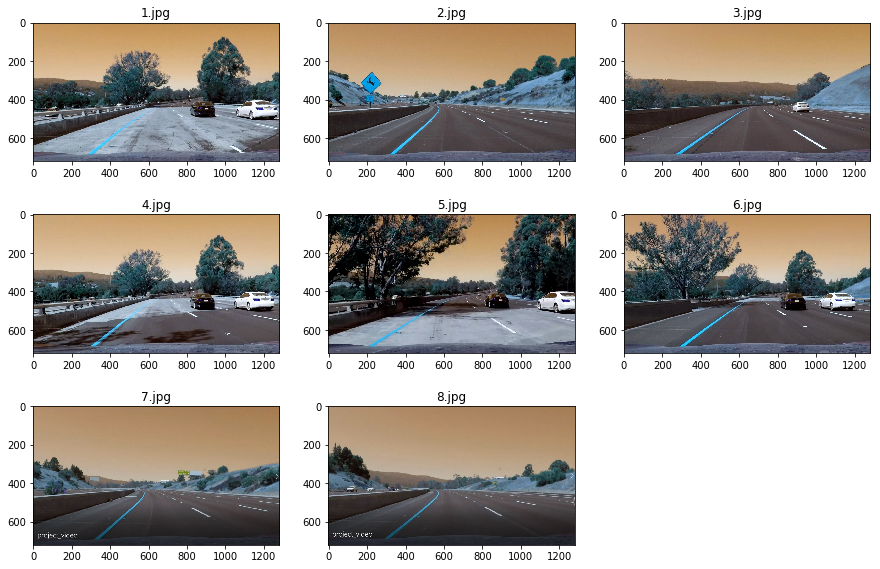

In [111]:
#from collections import deque

#initiate a bbox to store bboxes that occured in the several frames
global cache_box
cache_box = []
path = './test_images/'

fig = plt.figure(figsize=(15,10))

for i in range(1,9):
    image = cv2.imread(path + f'test{i}.jpg')
    imgcopy=np.copy(image)
    fig.add_subplot(3,3,i)
    draw = heatmap_pipeline(imgcopy,frame=6)
    plt.title(f'{i}.jpg')
    plt.imshow(draw)

# Conclusion:

### By applying CNN and SVM model at the same time, and heatmap threshold, false positive and duplicate windows were almost removed completely.  

# 6. Apply the pipeline to video

In [115]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

#from collections import deque

#initiate a bbox to store bboxes that occured in the several frames
global cache_bbox
cache_box = []

output = 'test_output1.mp4'
clip1 = VideoFileClip("test_video.mp4")
project_clip = clip1.fl_image(heatmap_pipeline) 
project_clip.write_videofile(output, audio=False)

print('Finished')

[MoviePy] >>>> Building video test_output1.mp4
[MoviePy] Writing video test_output1.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [00:42<00:00,  1.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_output1.mp4 

Finished


In [87]:
HTML("""
<video width="640" height="480" controls>
  <source src="{0}">
</video>
""".format(output))

In [67]:
a = np.arange(12).reshape(3,4)
a

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [68]:
a > 5

array([[False, False, False, False],
       [False, False,  True,  True],
       [ True,  True,  True,  True]])

In [69]:
a[a>5]

array([ 6,  7,  8,  9, 10, 11])

In [70]:
b = a * 1.2
b

array([[ 0. ,  1.2,  2.4,  3.6],
       [ 4.8,  6. ,  7.2,  8.4],
       [ 9.6, 10.8, 12. , 13.2]])

In [71]:
b > 11

array([[False, False, False, False],
       [False, False, False, False],
       [False, False,  True,  True]])

In [72]:
b[(b>10) & (b<13)]
b

array([[ 0. ,  1.2,  2.4,  3.6],
       [ 4.8,  6. ,  7.2,  8.4],
       [ 9.6, 10.8, 12. , 13.2]])

In [73]:
c = np.zeros_like(b)
c

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [74]:
c[(a<3) & (b>10)] = 1
c

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [75]:
all_zeros = np.all(c==0)
all_zeros

True

In [76]:
d = np.ones_like(c)
d[a>0 & b >5] = 0

TypeError: ufunc 'bitwise_and' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [65]:
d

array([[1., 1., 1., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 0.]])